# groups_graphs_notebook

For this notebook to work from start to end without the need to change any directories, ensure that the folder FINAL_RNA/ is in our github folder chrisnatjulia/ and this notebook (groups_graphs_notebook.ipynb) is in our github folder chrisnatjulia/scripts/graphs_for_assembly_in_R/

# 1. Load Libraries and set parameters

If you don't have these libraries installed, go to R and install them manually first

In [1]:
library(dplyr)
library(data.table)
library(ggplot2)
library(viridis)
library(vegan)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: viridisLite

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



Add subset flag and percentage difference flag

First make barplot with everything; sort based on group name and make color vector gradients based on superkingsom, then plot

Then, for bubble plot, make separate data preparation cell; subset data frame; if percentage difference flag on then sort by that else sort by average rel. proportion; then print percentage difference next to every row.
For plot, colour bubbles and row names based on super kingdom, choose middle colour from barplot gradients

Indicate assemblers, classifiers, and mappers you used (**important: in the order they appear in the FINAL_RNA/ folder)**

In [2]:
assemblers <- c("IDBA-tran", "rnaSPAdes", "Trinity")
classifiers <- c("BLAST_nt", "BLAST_SILVA", "CREST")
mappers <- c("Bowtie2", "BWA")

min_abundance_filtering <- TRUE
if (min_abundance_filtering == TRUE) {min_abundance <- 0.01} #set minimum relative abundance of group in total abundances to keep group
percentage_diff <- FALSE #set true if groups should be sorted for bubble plot based on percentage differences between min and max of different pipelines

# 2. Read in data and tidy it up

Reading in data from all files within the FINAL_RNA/ folder


In [3]:
files_list_full_path <- list.files("../../FINAL_RNA/", pattern = "\\.txt$", , full.names=T) # For fread to work (needs full path in our case)
files_list_just_names <- list.files("../../FINAL_RNA/", pattern = "\\.txt$") # To make names for the dataframes based on file names
dataframe_names_list <- gsub("\\_final.txt$", "", files_list_just_names)
all_list <- lapply(files_list_full_path, fread) # Creating a list with data frames of all files
names(all_list) <- dataframe_names_list # Changing the names of the dataframes in list
tax_full_dataframes <- lapply(all_list, function(x) x%>% select(superkingdom:genus)) # Creating a list with full taxanomy of each data frame
counts_dataframes <- lapply(all_list, function(x) x%>% select(counts)) # Creating a list with counts of each data frame


Create functions to generate vectors that contain taxonomic groups


In [4]:
# Create function to generate taxlist vector with phylum per row in taxonomy table (or if phylum = NA, then superkingdom: Unkown)
make_tax_phylum_dataframe <- function(tax)
  {
    taxlastrow <- nrow(tax)
    taxlist <- rep(NA,nrow(tax))
    for (i in 1:nrow(tax))
    { if (is.na(tax[i,1]) == TRUE)
      { taxlist[i] <- "NA"
    } else if (tax[i,1] == "Unknown")
      { taxlist[i] <- "Unknown"
    } else if (is.na(tax[i,3]) == TRUE)
      { taxlist[i] <- paste(tax[i,1], ": Unknown", sep="")
    } else
      { taxlist[i] <- paste(tax[i,1], ": ", tax[i,3], sep="") }
    }
    taxdf <- as.data.frame(taxlist)
    return(taxdf)
  }

# Create function to generate taxlist vector with superkingdom per row in taxonomy table
make_tax_superkingdom_dataframe <- function(tax)
{
  taxlastrow <- nrow(tax)
  taxlist <- rep(NA,nrow(tax))
  for (i in 1:nrow(tax))
  { if (is.na(tax[i,1]) == TRUE)
      { taxlist[i] <- "NA"
      } else
      { taxlist[i] <- tax[i,1] }
  }
  taxdf <- t(as.data.frame(taxlist))
  return(taxdf)
}

Apply taxlist fuction to list of dataframes (phylum and superkingdom assignments in separate dataframe lists), **might take a while**


In [5]:
tax_superkingdom_dataframes <- lapply(tax_full_dataframes, make_tax_superkingdom_dataframe)
tax_phylum_dataframes <- lapply(tax_full_dataframes, make_tax_phylum_dataframe)

Combine read count and phylum/superkingdom information and aggregate based on groups


In [6]:
aggregate_tax_groups <- function(group_counts_dataframes)
  {
    setNames(aggregate(unlist(group_counts_dataframes[[2]])~unlist(group_counts_dataframes[[1]]),data=group_counts_dataframes,FUN=sum), c("Group", "Reads"))
  }

phylum_counts_dataframes <- mapply(cbind, tax_phylum_dataframes, counts_dataframes, SIMPLIFY=FALSE)
phylum_agg_dataframes <- lapply(phylum_counts_dataframes, aggregate_tax_groups)

superkingdom_counts_dataframes <- mapply(cbind, tax_superkingdom_dataframes, counts_dataframes, SIMPLIFY=FALSE)
superkingdom_agg_dataframes <- lapply(superkingdom_counts_dataframes, aggregate_tax_groups)

Merge all dataframes in list


In [7]:
# For phyla
merged_phylum <- phylum_agg_dataframes %>%
  Reduce(function(df1,df2) full_join(df1,df2,by="Group"), .) %>% 
  mutate_each(funs(replace(., which(is.na(.)), 0)))
colnames(merged_phylum) <- c("Group", dataframe_names_list)
merged_phylum_ordered <- merged_phylum[order(as.character(merged_phylum$Group)),] # Order groups alphabetically
merged_phylum_ordered$Group <- factor(merged_phylum_ordered$Group, levels=merged_phylum_ordered$Group) # Command to keep order for ggplot2
         
# For superkingdoms
merged_superkingdom <- superkingdom_agg_dataframes %>%
  Reduce(function(df1,df2) full_join(df1,df2,by="Group"), .) %>% 
  mutate_each(funs(replace(., which(is.na(.)), 0)))
colnames(merged_superkingdom) <- c("Group", dataframe_names_list)
merged_superkingdom_ordered <- merged_superkingdom[order(as.character(merged_superkingdom$Group)),] # Order groups alphabetically
merged_superkingdom_ordered$Group <- factor(merged_superkingdom_ordered$Group, levels=merged_superkingdom_ordered$Group) # Command to keep order for ggplot2

Warning message:
“Column `Group` joining factors with different levels, coercing to character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing int

Generate relative abundances (to transform absolute abundances into compositional data)


In [8]:
# For phyla
phylum_relAbu <- cbind(merged_phylum_ordered$Group, decostand(select(merged_phylum_ordered, -Group), "total", 2))
colnames(phylum_relAbu) <- c("Group", dataframe_names_list)

# For superkingdoms
superkingdom_relAbu <- cbind(merged_superkingdom_ordered$Group, decostand(select(merged_superkingdom_ordered, -Group), "total", 2))
colnames(superkingdom_relAbu) <- c("Group", dataframe_names_list)
#write.csv(superkingdom_relAbu,"../../superkingdom_relAbu.csv", row.names = FALSE) # Uncomment if you want to save data frame

Add column with Average and Max to phylum relative abundance data, needed for next two cells

In [9]:
phylum_relAbu$Ave <- rowMeans(select(phylum_relAbu, -Group))
phylum_relAbu$Max <- do.call(pmax, select(phylum_relAbu, -Group, -Ave))

__If min_abundance_filtering flag at beginning activated__: subsample groups based on relative abundance of each group in total abundances (limit set at beginning). For each group, the maximum abundance from all pipeline results is identified and used to determine the relative abundance of each group in total abundances.

In [10]:
## For next step, data can be subsampled based set minimum relative abundance of groups in total abundance based on maximum per group in pipelines
if (min_abundance_filtering == TRUE)
{
    phylum_relAbu_orderAve <- phylum_relAbu
    phylum_relAbu_orderAve <- phylum_relAbu_orderAve[order(phylum_relAbu_orderAve$Ave),]
    phylum_relAbu_orderAve_subset <- subset(phylum_relAbu_orderAve, phylum_relAbu_orderAve$Max >= min_abundance)
    phylum_relAbu_orderAve_subset <- phylum_relAbu_orderAve_subset[order(phylum_relAbu_orderAve_subset$Max),] # Order groups based on group names
    phylum_relAbu_orderAve_subset$Group <- factor(phylum_relAbu_orderAve_subset$Group, levels=phylum_relAbu_orderAve_subset$Group)
    phylum_relAbu_orderAve_subset <- select(phylum_relAbu_orderAve_subset, -Ave, -Max)
}

Order groups based on names or, if percentage_diff flag activated, based on percentage difference between group minimum and maximum of the different pipelines.

In [11]:
# TO DO: get rid of following chunk when 100% sure that I'll just plot average abundances
## Order by group names
#phylum_relAbu_orderGroup <- phylum_relAbu[order(phylum_relAbu$Group),] # Order groups based on group names
#phylum_relAbu_orderGroup$Group <- factor(phylum_relAbu_orderGroup$Group, levels=phylum_relAbu_orderGroup$Group) # Command to keep order for ggplot2
#write.csv(phylum_relAbu_orderGroup,"../../phylum_relAbu_orderGroup.csv", row.names = FALSE) # Uncomment if you want to save data frame

## Order by group names (just average per all pipelines for overview)
phylum_relAbu_orderGroup <- phylum_relAbu[order(phylum_relAbu$Group),] # Order groups based on group names
phylum_relAbu_orderGroup$Group <- factor(phylum_relAbu_orderGroup$Group, levels=phylum_relAbu_orderGroup$Group) # Command to keep order for ggplot2
phylum_relAbu_orderGroup_Ave <- select(phylum_relAbu_orderGroup, Group, Ave)
#write.csv(phylum_relAbu_orderGroup,"../../phylum_relAbu_orderGroup.csv", row.names = FALSE) # Uncomment if you want to save data frame

## Order by percentage difference between group abundance minimum and maximum with different pipelines
if (percentage_diff == TRUE)
{   if (min_abundance_filtering == TRUE) {phylum_relAbu_orderPercDiff <- phylum_relAbu_orderAve_subset} else {phylum_relAbu_orderPercDiff <- phylum_relAbu}
    phylum_relAbu_orderPercDiff$Diff <- do.call(pmax, select(phylum_relAbu_orderPercDiff, -Group))-do.call(pmin, select(phylum_relAbu_orderPercDiff, -Group))
    phylum_relAbu_orderPercDiff$PercDiff <- phylum_relAbu_orderPercDiff$Diff/rowMeans(select(phylum_relAbu_orderPercDiff, -Group))
    phylum_relAbu_orderPercDiff <- phylum_relAbu_orderPercDiff[order(phylum_relAbu_orderPercDiff$PercDiff),] # Order groups based on percentage difference
    phylum_relAbu_orderPercDiff <- select(phylum_relAbu_orderPercDiff, -Diff, -PercDiff)
    phylum_relAbu_orderPercDiff$Group <- factor(phylum_relAbu_orderPercDiff$Group, levels=phylum_relAbu_orderPercDiff$Group) # Command to keep order for ggplot2
    #write.csv(phylum_relAbu_orderPercDiff,"../../phylum_relAbu_orderPercDiff.csv", row.names = FALSE) # Uncomment if you want to save data frame
}

Determine which of the generated datasets is used for bubbleplot

In [12]:
bubbleplot_relAbu <- select(phylum_relAbu_orderGroup, -Ave, -Max)
if (min_abundance_filtering == TRUE) {bubbleplot_relAbu <- phylum_relAbu_orderAve_subset}
if (percentage_diff == TRUE) {bubbleplot_relAbu <- phylum_relAbu_orderPercDiff}
bubbleplot_relAbu$Superkingdoms <- str_extract(bubbleplot_relAbu$Group, "^[^:]+") #Get superkingdoms of every group to colour groups based on superkingdoms in bubbleplot

# 3. Prepare data for plotting

Transform ("melt") dataset to be able to generate stacked barplots


In [13]:
superkingdom_viridis_colors <- viridis_pal(option = "D")(nrow(superkingdom_relAbu)) # Choosing viridis colors (colorblindfriendly), as many colors from gradient as numbers of groups
set.seed(002)
colorvec_superkingdom <- sample(superkingdom_viridis_colors) # Randomize color order, otherwise bars next to each other are hard to distinguish
names(colorvec_superkingdom) <- superkingdom_relAbu$Group

In [14]:
phylum_relAbu_orderGroup_Ave_melted <- reshape2::melt(phylum_relAbu_orderGroup_Ave,id.vars = "Group", variable.name="Average", value.name="Reads")
bubbleplot_relAbu_melted <- reshape2::melt(bubbleplot_relAbu,id.vars = c("Group", "Superkingdoms"), variable.name="Combination", value.name="Reads")
superkingdom_melted <- reshape2::melt(superkingdom_relAbu,id.vars = "Group", variable.name="Combination", value.name="Reads")

Make functions to generate Assembler, Classifier, and Mapper columns for the different combinations in melted dataset so that the barplots can be grouped by these


In [15]:
number_of_assemblers <- length(assemblers)
number_of_classifiers <- length(classifiers)
number_of_mappers <- length(mappers)

# Generate assembler column
make_assembler_column <- function(groups_melted)
{
    assembler_column <- NULL 
    for (i in 1:number_of_assemblers) 
    {
      loopresult <- rep(assemblers[i], nrow(groups_melted)/number_of_assemblers)
      assembler_column <- c(assembler_column,loopresult)
    }
return(assembler_column)
}

# Generate classifier column
make_classifier_column <- function(groups_melted)
{
    classifier_column <- NULL
    rep_classifier <- 1
    while (rep_classifier<number_of_assemblers+1)
    {
      for (i in 1:number_of_classifiers) 
      {
        loopresults <- rep(classifiers[i], nrow(groups_melted)/number_of_assemblers/number_of_classifiers)
        classifier_column <- c(classifier_column,loopresults)
      }
    rep_classifier <- rep_classifier+1
    }
return(classifier_column)
}

# Generate mapper column
make_mapper_column <- function(groups_melted)
{
    mapper_column <- NULL
    rep_mapper <- 1
    while (rep_mapper<number_of_assemblers*number_of_classifiers+1)
    {
      for (i in 1:number_of_mappers)
      {
        loopresults <- rep(mappers[i], nrow(groups_melted)/number_of_assemblers/number_of_classifiers/number_of_mappers)
        mapper_column <- c(mapper_column,loopresults)
      }
      rep_mapper <- rep_mapper+1
    }
return(mapper_column)
}

Generate Assembler, Classifier, and Mapper columns for the different combinations in melted dataset and attach new Assembler, Classifier, and Mapper columns to melted dataframes


In [16]:
# For phyla - ordered by group names
assembler_column_phylum_orderGroup <- make_assembler_column(phylum_relAbu_orderGroup_Ave_melted)
classifier_column_phylum_orderGroup <- make_classifier_column(phylum_relAbu_orderGroup_Ave_melted)
mapper_column_phylum_orderGroup <- make_mapper_column(phylum_relAbu_orderGroup_Ave_melted)

phylum_relAbu_orderGroup_Ave_melted$Assembler <- assembler_column_phylum_orderGroup
phylum_relAbu_orderGroup_Ave_melted$Classifier <- classifier_column_phylum_orderGroup
phylum_relAbu_orderGroup_Ave_melted$Mapper <- mapper_column_phylum_orderGroup

# For phyla - ordered by percentage difference between group abundance minimum and maximum, based on the different pipelines
assembler_column_bubbleplot <- make_assembler_column(bubbleplot_relAbu_melted)
classifier_column_bubbleplot <- make_classifier_column(bubbleplot_relAbu_melted)
mapper_column_bubbleplot <- make_mapper_column(bubbleplot_relAbu_melted)

bubbleplot_relAbu_melted$Assembler <- assembler_column_bubbleplot
bubbleplot_relAbu_melted$Classifier <- classifier_column_bubbleplot
bubbleplot_relAbu_melted$Mapper <- mapper_column_bubbleplot

# For superkingdoms
assembler_column_superkingdom <- make_assembler_column(superkingdom_melted)
classifier_column_superkingdom <- make_classifier_column(superkingdom_melted)
mapper_column_superkingdom <- make_mapper_column(superkingdom_melted)

superkingdom_melted$Assembler <- assembler_column_superkingdom
superkingdom_melted$Classifier <- classifier_column_superkingdom
superkingdom_melted$Mapper <- mapper_column_superkingdom

# 4. Plot data

## 4.1 Make colours

### 4.1.1 Make colours for superkingdoms and phyla, respectively, only based on the viridis palette (with random colour order to be able to better distinguish groups)

In [17]:
phylum_viridis_colors <- viridis_pal(option = "D")(nrow(phylum_relAbu)) # Choosing viridis colors (colorblindfriendly), as many colors from gradient as numbers of groups
set.seed(002)
colorvec_phylum <- sample(phylum_viridis_colors) # Randomize color order, otherwise bars next to each other are hard to distinguish

superkingdom_viridis_colors <- viridis_pal(option = "D")(nrow(superkingdom_relAbu)) # Choosing viridis colors (colorblindfriendly), as many colors from gradient as numbers of groups
set.seed(002)
colorvec_superkingdom <- sample(superkingdom_viridis_colors) # Randomize color order, otherwise bars next to each other are hard to distinguish
names(colorvec_superkingdom) <- superkingdom_relAbu$Group

### 4.1.2 Make colours for phyla based on corresponding superkingdoms (to be able to identify groups AND superkingdoms based on colours)

Make vector for number of phyla per superkingdom


In [18]:
# Attach ":" to all found superkingdom names but "NA" and "Unknown"
grep_strings_raw <- merged_superkingdom_ordered$Group
grep_strings <- NULL
for (i in grep_strings_raw)
{   if (i == "NA")
    { loopresult_grep <- "NA"
  } else if (i == "Unknown")
    { loopresult_grep <- "Unknown"
  } else
    { loopresult_grep <- paste0(i, ":") }
    grep_strings <- c(grep_strings, loopresult_grep)
} 

# Grep these from the phylum names, count number, and put in vector
lengths_colors_groups <- NULL
for (i in grep_strings) 
{
    loopresults_colours <- length(grep(i, merged_phylum_ordered$Group))
    lengths_colors_groups <- c(lengths_colors_groups,loopresults_colours)
}
names(lengths_colors_groups) <- merged_superkingdom_ordered$Group

Make colourvector for phyla based on corresponding superkingdom, using one **self-made, not colourblind-friendly** colour palette per superkingdom


In [19]:
colfunc_archaea <- colorRampPalette(c("aquamarine", "blue3"))
colours_archaea <- colfunc_archaea(lengths_colors_groups["Archaea"])
colfunc_bacteria <- colorRampPalette(c("lightgreen", "darkgreen"))
colours_bacteria <- colfunc_bacteria(lengths_colors_groups["Bacteria"])
colfunc_eukaryota <- colorRampPalette(c("lightpink", "red3"))
colours_eukaryota <- colfunc_eukaryota(lengths_colors_groups["Eukaryota"])
colours_NA <- "black"
colours_unknown <- "gray"
colfunc_viruses <- colorRampPalette(c("goldenrod1", "khaki"))
colours_viruses <- colfunc_viruses(lengths_colors_groups["Viruses"])

colorvec_phylum_superkingdoms <- c(colours_archaea, colours_bacteria, colours_eukaryota, colours_NA, colours_unknown, colours_viruses)

### 4.1.3 Make colourvector for bubbleplot based on superkingdoms, matching the colours for superkingdoms in 4.1.1

In [20]:
bubbleplot_superkingdom_cols <- NULL
for (i in bubbleplot_relAbu$Superkingdoms)
{
    ind <- which(names(colorvec_superkingdom) == i)
    loopresults <- colorvec_superkingdom[ind]
    bubbleplot_superkingdom_cols <- c(bubbleplot_superkingdom_cols,loopresults)
}

## 4.2 Plot data assigned to superkingdoms (can probably be deleted)

Note: if you want to save the plots using the script, uncomment the ggsave commands after each plot

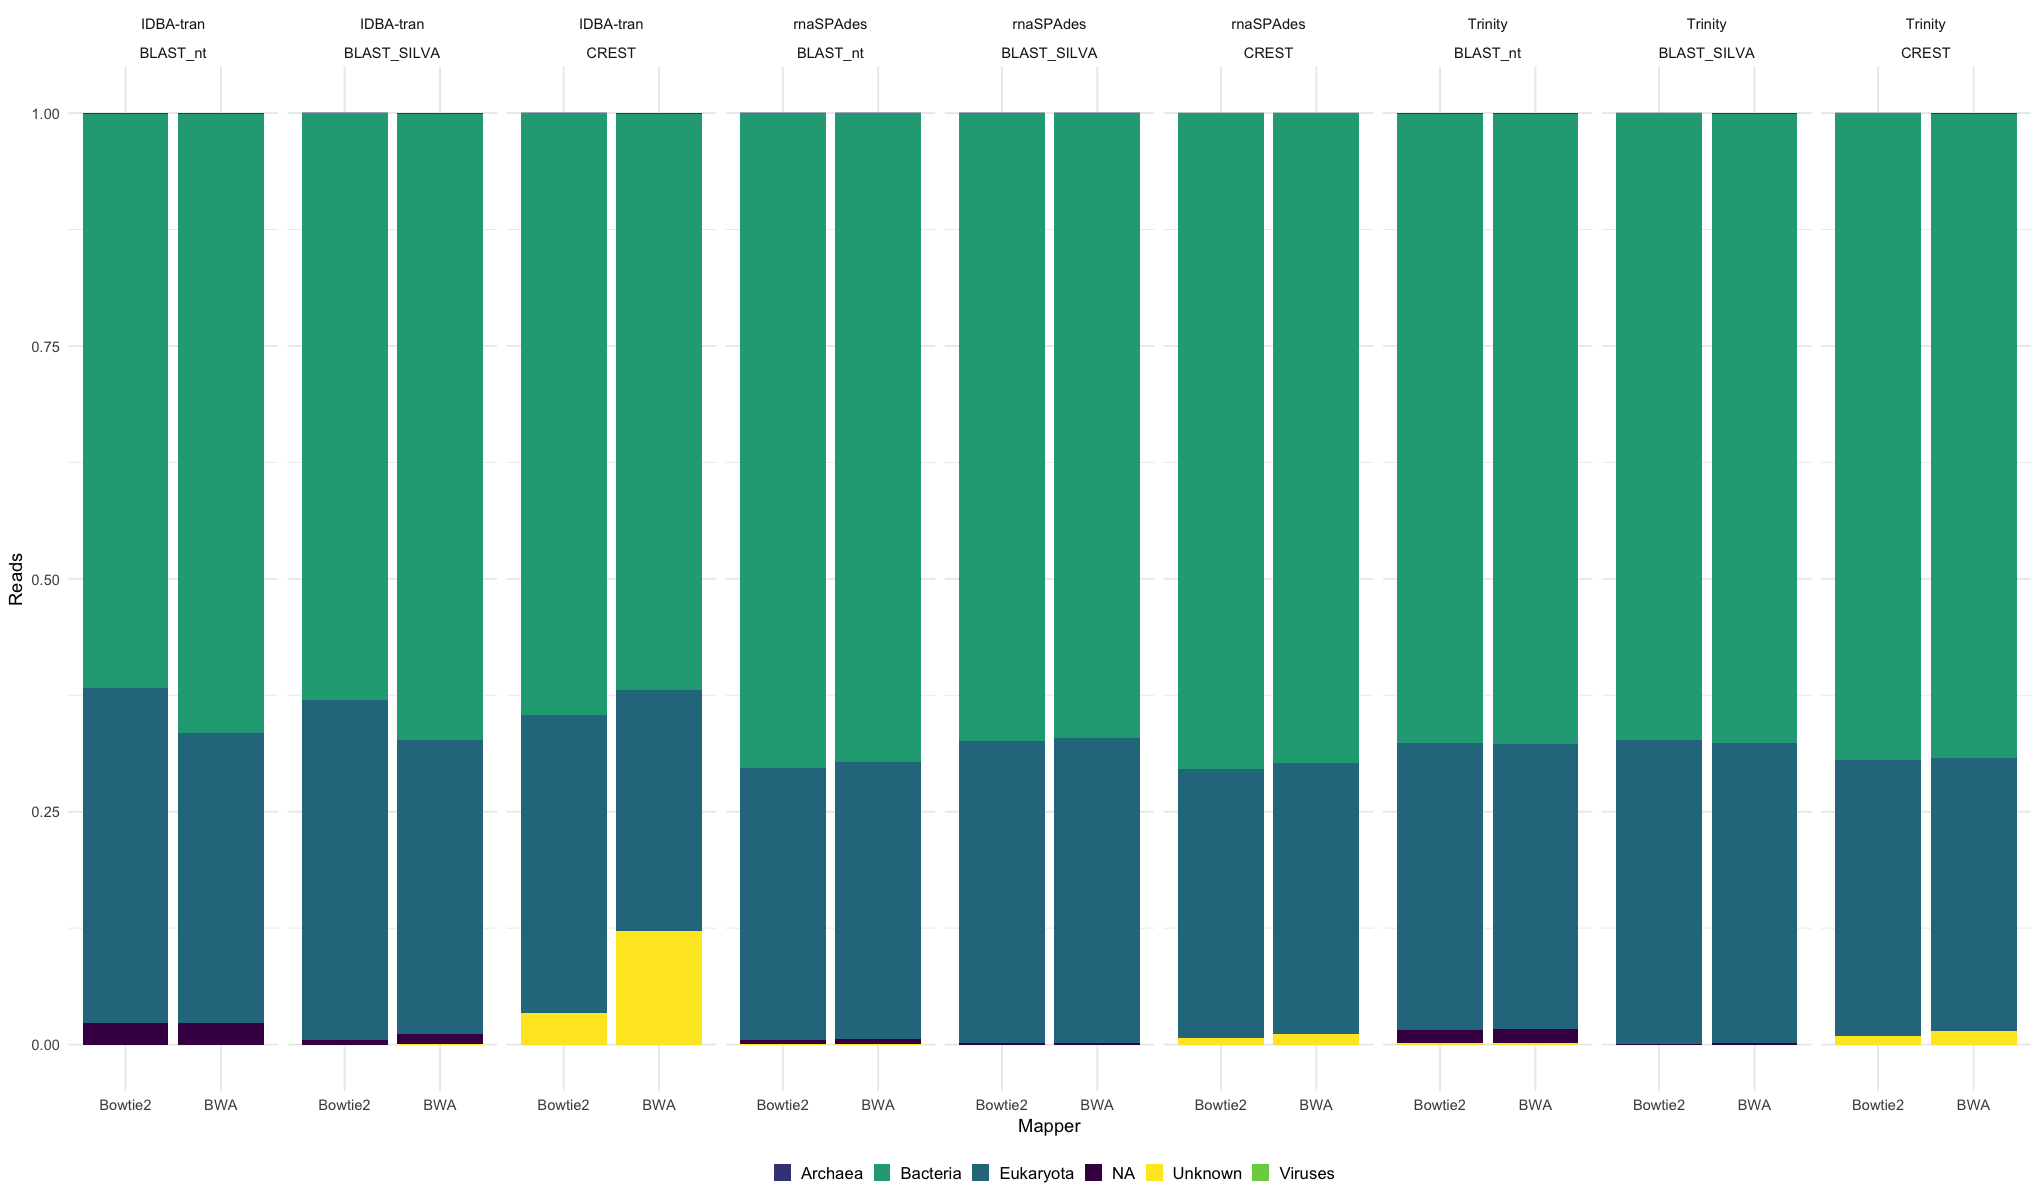

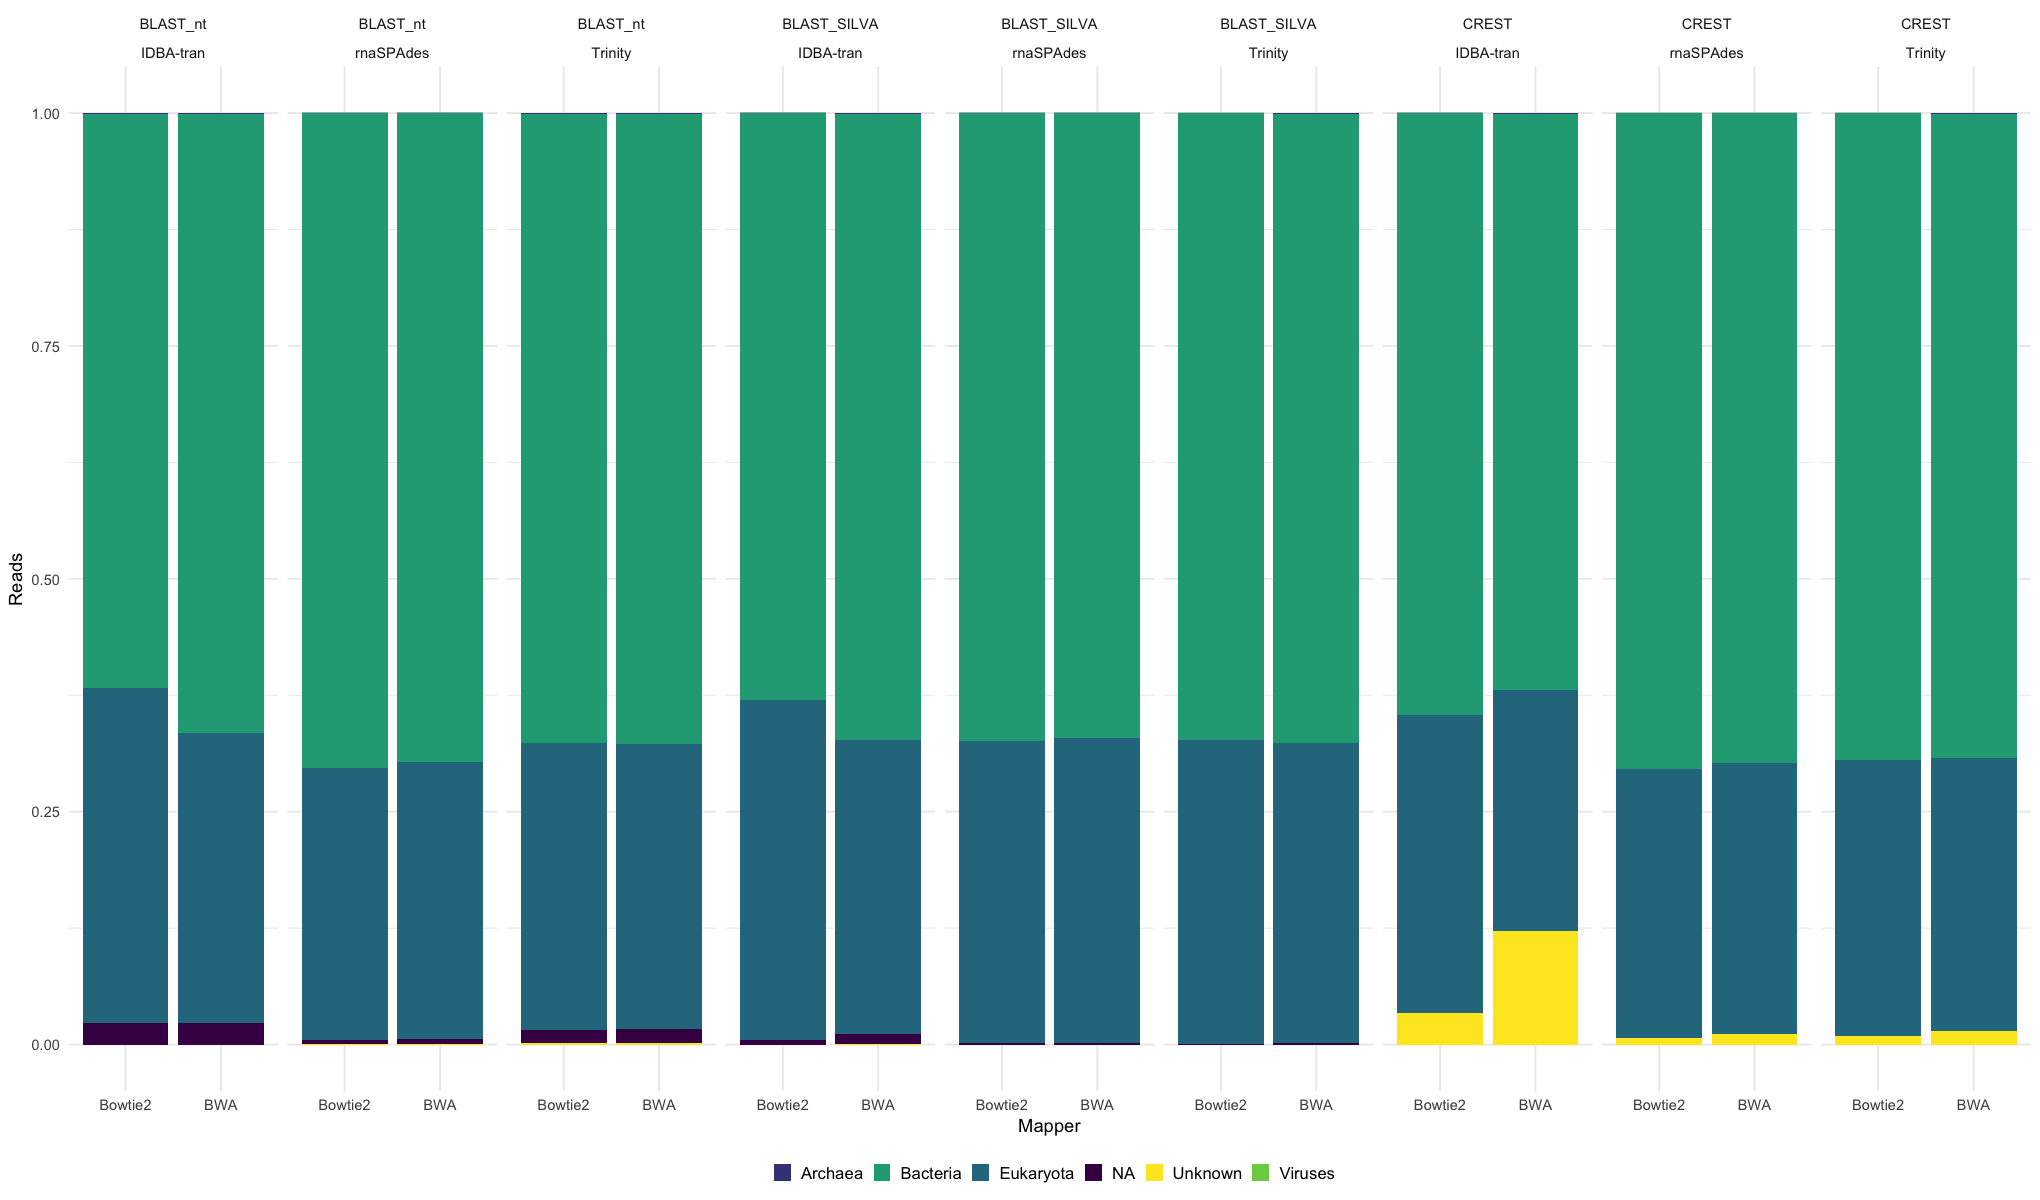

In [21]:
# Plot grouped by assembler and classifier
plot4<-ggplot(superkingdom_melted, aes(x = Mapper, y = Reads, fill = Group))+
  #geom_bar(stat = 'identity', position = 'stack', colour="black")+
  geom_bar(stat = 'identity', position = 'stack')+
# facet_grid(Assembler ~ Classifier, scales = "free", space = "free")+
  facet_grid( ~ Assembler + Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_superkingdom)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot4
#ggsave("Plot4.png", plot=plot4,  device="png",  width=240, units="mm")

# Plot grouped by classifier and assembler
plot5<-ggplot(superkingdom_melted, aes(x = Mapper, y = Reads, fill = Group))+
  #geom_bar(stat = 'identity', position = 'stack', colour="black")+
  geom_bar(stat = 'identity', position = 'stack')+
# facet_grid(Assembler ~ Classifier, scales = "free", space = "free")+
  facet_grid( ~ Classifier + Assembler , scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_superkingdom)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
options(repr.plot.width=17, repr.plot.height=10)
plot5
#ggsave("Plot5.png", plot=plot5,  device="png",  width=240, units="mm")

## 4.3 Plot data assigned to phylum

Note: if you want to save the plots using the script, uncomment the ggsave commands after each plot

### 4.3.1 Phylum average across all pipelines

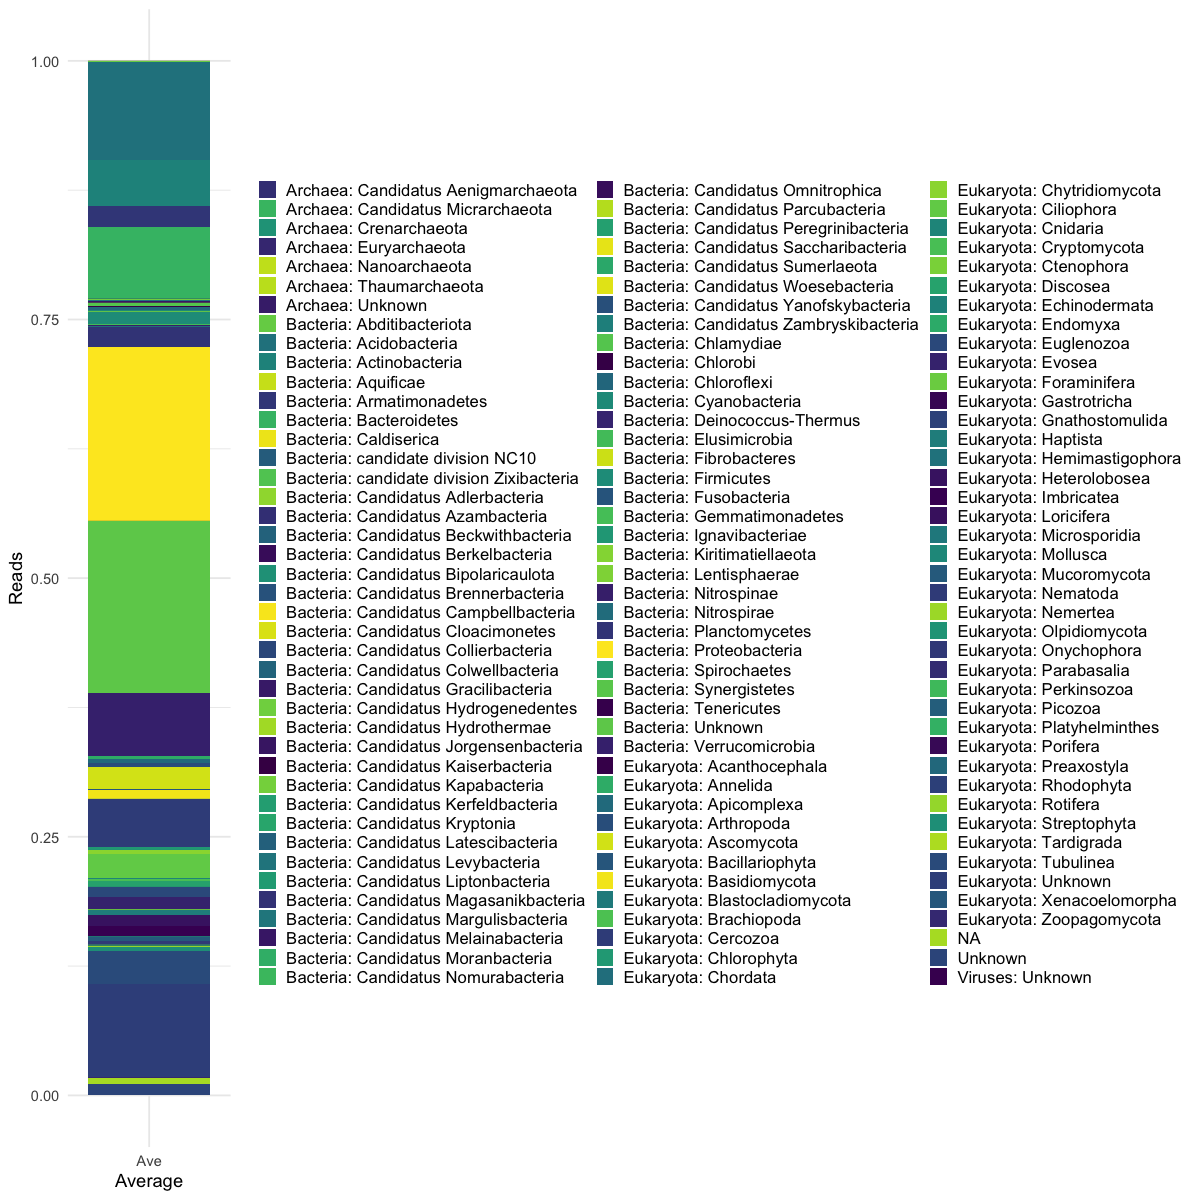

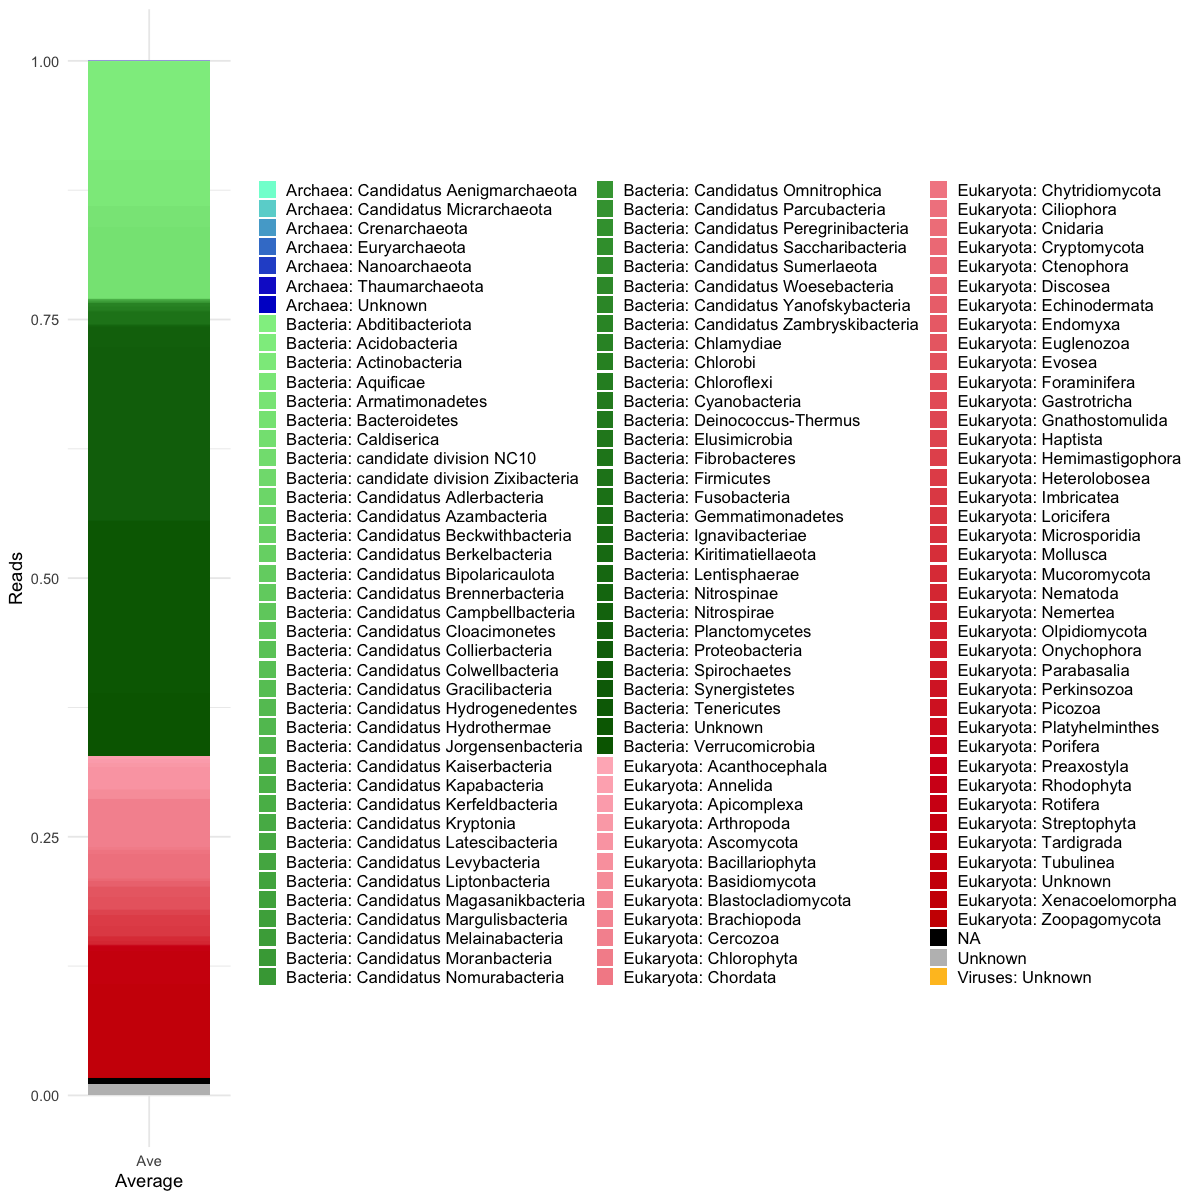

In [22]:
# Plot grouped by assembler and classifier
plot8<-ggplot(phylum_relAbu_orderGroup_Ave_melted, aes(x = Average, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  theme_minimal()+
  scale_fill_manual(values=colorvec_phylum)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="right")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=3,byrow=FALSE))
options(repr.plot.width=10, repr.plot.height=10)
plot8
#ggsave("Plot8.png", plot=plot8,  device="png",  width=240, units="mm")

# Plot grouped by assembler and classifier
plot9<-ggplot(phylum_relAbu_orderGroup_Ave_melted, aes(x = Average, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  theme_minimal()+
  scale_fill_manual(values=colorvec_phylum_superkingdoms)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="right")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=3,byrow=FALSE))
options(repr.plot.width=10, repr.plot.height=10)
plot9
#ggsave("Plot9.png", plot=plot9,  device="png",  width=240, units="mm")

## 4.5 Plot relative abundances as bubble plot to show differences between pipelines

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


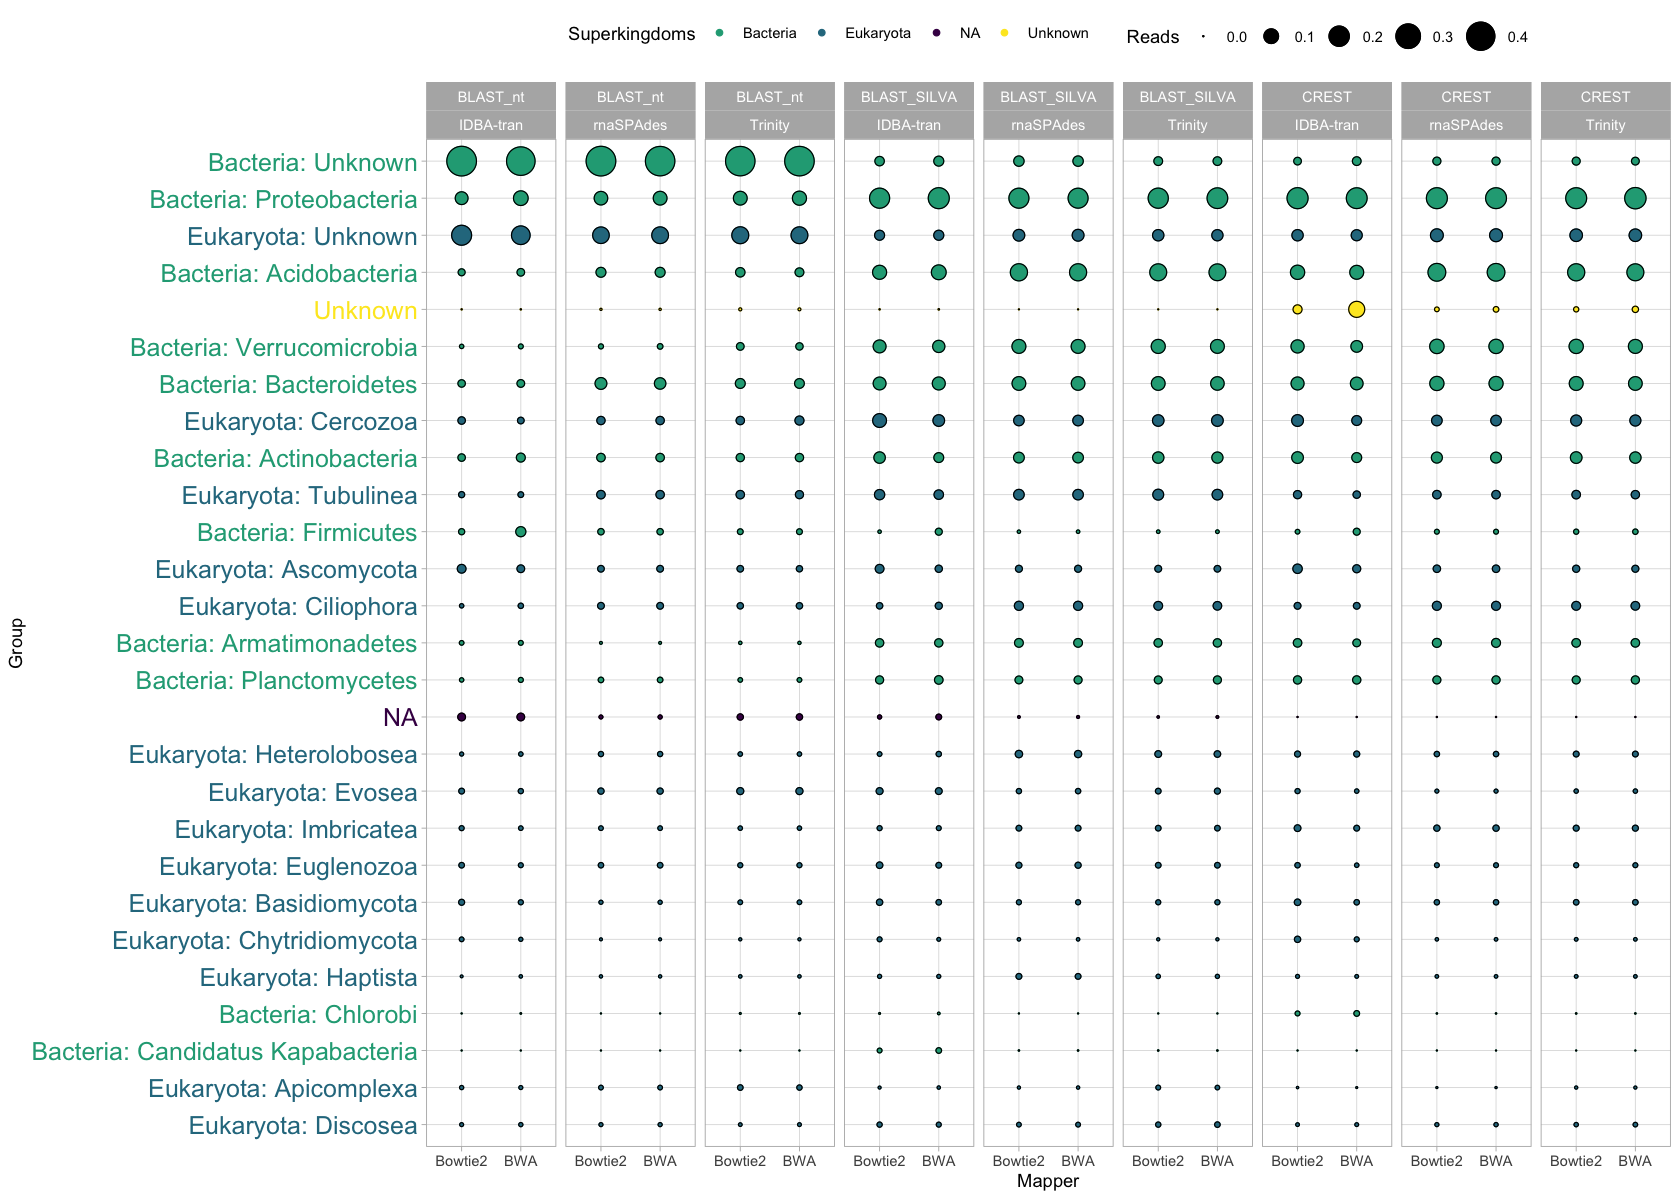

In [24]:
plot21<-ggplot(bubbleplot_relAbu_melted, aes(x=Mapper, y=Group))+
  geom_point(aes(colour=Superkingdoms, size=Reads))+
  geom_point(aes(size=Reads), shape=1, colour="black")+
  facet_grid( ~ Classifier + Assembler, scales = "free", space = "free")+
  #theme_void()+
  theme_light()+
  scale_color_manual(values=bubbleplot_superkingdom_cols) +
  theme(legend.position="top")+
  scale_size(range = c(0, 8))+
  theme(axis.text.y = element_text(colour=bubbleplot_superkingdom_cols, size=15))
options(repr.plot.width=14)
plot21